# Porting an analysis from local to distributed

In this pair of notebooks, we will develop a prototype unsupervised analysis with sklearn and then port it to use Spark, as we might in real life.

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

## Porting our analysis to a distributed setting using Spark DataFrames

First, read the input file

In [2]:
from pyspark.sql import SparkSession

session=SparkSession.builder.getOrCreate()

We can specify `.read` options in two equivalent ways:

In [3]:
df=session.read.csv('sales_segments.csv',sep='^',header=True,inferSchema=True)

### Extract KPIs

A direct transliteration of what we did with sklearn: columnwise arithmetic

In [4]:
df2=df.select((df['revenue_amount_seg']/df['bookings_seg']).alias('revenue'),
              (df['fuel_surcharge_amount_seg']/df['bookings_seg']).alias('tax'))

In [ ]:
#el siguiente paso es hacer el clustering en spark. en el notebook 5 lo veremos más en profundidad.
#ML en spark está dividido en 2 módulos mllib y ml. Nosotros usaremos Spark.ML

## Machine Learning in Spark

### `spark.mllib` and `spark.ml`

`spark.mllib` was the original Spark Machine Learning package. It is based on RDDs. It's now on maintenance mode.

Since the focus on DataFrames, `spark.ml` is the primary ML package. It's designed around DataFrames. 

Somewhat confusingly, "Spark MLLIB" is the name of the library, and it comprises both.

https://spark.apache.org/docs/2.2.1/ml-guide.html
https://spark.apache.org/docs/2.2.1/api/python/pyspark.ml.html

### Transformers, Estimators and Models

In Spark ML, a Transformer is an object that represents a transformation from a DataFrame into another DataFrame.

Many preprocessing and feature extraction steps are represented by Transformers. In general, this happens when they don't have to learn anything from the dataset itself, which means they implement the `transform` but not the `fit` method.

When the transformation does depend on the dataset, the transformation is represented by an Estimator. An Estimator implements a `fit` method that generates a Model, which is a Transformer.

All Machine Learning models are Estimators, and many feature extraction steps are as well.

https://spark.apache.org/docs/2.2.0/ml-pipeline.html

### Assemble features

In [6]:
#un transformer que trendremos que usar es el vector assembler

from pyspark.ml.feature import VectorAssembler

#este vector aseempler nos devolverá un dataframe con una columna nueva con la concatenación que nosotros le digamos.
va=VectorAssembler(inputCols=['revenue','tax'],outputCol='features')
#este vector assembler sabe transformar
assembled=va.transform(df2)
assembled.show(5)

+------------------+-----------------+--------------------+
|           revenue|              tax|            features|
+------------------+-----------------+--------------------+
|             33.56|              7.3|         [33.56,7.3]|
|              61.2|             25.5|         [61.2,25.5]|
| 71.86842105263158|12.31578947368421|[71.8684210526315...|
|27.116666666666664|            13.31|[27.1166666666666...|
|               0.0|            15.91|         [0.0,15.91]|
+------------------+-----------------+--------------------+
only showing top 5 rows



### Training our model

Just like in sklearn, we use a `.fit` method. The difference is that Estimators are stateless: the software object we call kmeans doesn't learn, that is, it doesn't change its state like sklearn models do (remember the underscore-suffixed attributes of sklearn models, which are generated from the data). 

What it does is generate a new object, the one we call model, which is a Transformer. This object contains the information necessary to `.transform` our data, which is the method name spark.ml uses in place of `.predict`.

In [9]:
from pyspark.ml.clustering import KMeans

km=KMeans(predictionCol='cluster', k=8)
#tras entrenarlo resulta en un km model
kmeans_model=km.fit(assembled)

### Assigning clusters



In [10]:
predicted=kmeans_model.transform(assembled).cache()
predicted.show(5)

+------------------+-----------------+--------------------+-------+
|           revenue|              tax|            features|cluster|
+------------------+-----------------+--------------------+-------+
|             33.56|              7.3|         [33.56,7.3]|      0|
|              61.2|             25.5|         [61.2,25.5]|      0|
| 71.86842105263158|12.31578947368421|[71.8684210526315...|      0|
|27.116666666666664|            13.31|[27.1166666666666...|      0|
|               0.0|            15.91|         [0.0,15.91]|      0|
+------------------+-----------------+--------------------+-------+
only showing top 5 rows



In [ ]:
#ya tenemos el mismo df que en 4a, calculamos las medias las std y las z-score

### Z scores

Now we only need to calculate a z-score, so that we can score points as outliers or not outliers.

For that, we need the per-cluster mean and stddev for each of the variables.

Group by cluster and extract mean and stddev for each revenue and tax

In [11]:
from pyspark.sql import functions

stats=predicted\
    .groupBy('cluster')\
    .agg(functions.mean('revenue').alias('rev_avg'),
        functions.stddev('revenue').alias('rev_std'),
        functions.mean('tax').alias('tax_avg'),
        functions.stddev('tax').alias('tax_std'))
    
stats

DataFrame[cluster: int, rev_avg: double, rev_std: double, tax_avg: double, tax_std: double]

Join the aggregated results with the original DataFrame

In [12]:
annotated=predicted.join(stats,on='cluster',how='left')
annotated

DataFrame[cluster: int, revenue: double, tax: double, features: vector, rev_avg: double, rev_std: double, tax_avg: double, tax_std: double]

And we are ready to do the arithmetic!

In [14]:
calculated=annotated.select('revenue','tax','cluster',
                           ((annotated['revenue']-annotated['rev_avg'])/annotated['rev_std']).alias('zrev'),
                           ((annotated['tax']-annotated['tax_avg'])/annotated['tax_std']).alias('ztax')
                           )
calculated

DataFrame[revenue: double, tax: double, cluster: int, zrev: double, ztax: double]

In [21]:
zscores=calculated.withColumn('zscore_square',calculated['zrev']**2+calculated['ztax']**2)\
        .withColumn('outlier',calculated['zrev']**2+calculated['ztax']**2>9)

In [18]:

#esto no se puede hacer con una pipe con lo anterior por la inmutabilidad, con la sentencia anteior se crea un nuevo df el cual no tiene nombre.

### Plot the results

We use the standard Python scientific stack to plot

In [22]:
pd_df=zscores.select('revenue','tax','zscore_square','outlier').toPandas()

(-50, 700)

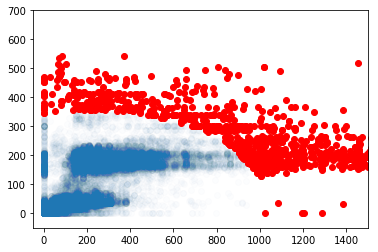

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sample=pd_df.sample(50000,random_state=42)
only_outliers=sample[sample['outlier']]

plt.scatter(sample['revenue'],sample['tax'],alpha=0.01)
plt.scatter(only_outliers['revenue'],only_outliers['tax'],c='Red')
plt.xlim((-50,1500))
plt.ylim((-50,700))

Looks just the same!

### Appendix: saving models

Just like in sklearn, we can save learned models so that we can share, import or deploy them. In this case we have an additional perk over sklearn: we can use the saved models in pyspark, but also in Scala or Java-based Spark applications. R is trickier, but it should be coming at some point.

In [24]:
kmeans_model.save('my_trained_kmeans')

In [25]:
#Para cargarlo:

from pyspark.ml.clustering import KMeansModel
#Uso método estático de kmeansmodel para cargarlo
rehydrated_kmens=KMeansModel.load('my_trained_kmeans')

In [26]:
rehydrated_kmens.transform(assembled)

DataFrame[revenue: double, tax: double, features: vector, cluster: int]

In [ ]:
#esto nos permite desacoplar la prediccion del training

#### Exercise

Turn this analysis into a Spark job (you can find an example in notebook 03).

Upload it to the cluster and run it.

In [38]:
#job.py

#1.inports, 2.read, 3.KPIs, 4.clustering, 5.groupby, 6.annotated_outliers

from __future__ import print_function
from pyspark import SparkContext
import sys

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: mysparkjob arg1 arg2 ", file=sys.stderr)
        exit(-1)
    #sc = SparkContext(appName="job")
    
    session=SparkSession.builder.getOrCreate()
    df=session.read.csv(sys.argv[1],sep='^',header=True,inferSchema=True)
    
    df2=df.select((df['revenue_amount_seg']/df['bookings_seg']).alias('revenue'),
              (df['fuel_surcharge_amount_seg']/df['bookings_seg']).alias('tax'))
    
    va=VectorAssembler(inputCols=['revenue','tax'],outputCol='features')
    assembled=va.transform(df2)
    
    km=KMeans(predictionCol='cluster', k=8)
    
    kmeans_model=km.fit(assembled)
    
    stats=predicted\
    .groupBy('cluster')\
    .agg(functions.mean('revenue').alias('rev_avg'),
        functions.stddev('revenue').alias('rev_std'),
        functions.mean('tax').alias('tax_avg'),
        functions.stddev('tax').alias('tax_std'))
    
    annotated=predicted.join(stats,on='cluster',how='left')
    
    calculated=annotated.select('revenue','tax','cluster',
                           ((annotated['revenue']-annotated['rev_avg'])/annotated['rev_std']).alias('zrev'),
                           ((annotated['tax']-annotated['tax_avg'])/annotated['tax_std']).alias('ztax')
                           )
    
    zscores=calculated.withColumn('zscore_square',calculated['zrev']**2+calculated['ztax']**2)\
        .withColumn('outlier',calculated['zrev']**2+calculated['ztax']**2>9)
    
    zscores.write.csv('zscores.csv')

AnalysisException: 'Path does not exist: file:/home/dsc/Desktop/Big Data Spark/-f;'

In [ ]:
#ver esta última linea del profesor para que funcione. Luego el procesor que se hizo en notebook3